# 0. Setup

In [1]:
# libraries

import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
from PIL import Image as PilImage
from typing import Tuple
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Lambda, Conv2D, BatchNormalization, MaxPooling2D, Dense, Flatten, Dropout, Activation
from tensorflow.keras.regularizers import L2

# working directories
WORKDIR = os.path.abspath('D:\\Users\\nbakotic\\iccecme-dataset') # get the path of this file - image metadata
IMAGESDIR = os.path.join(WORKDIR, 'imagespng256') # get the path of image folder

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### Plotting Functions

In [2]:
def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.show()


def plot_metrics(history, metric_name, title):
    plt.title(title)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()
    
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# 1.1 - Load and Process Metadata

In [4]:
# read metadata, drop target columns, original image size information and study description (natural language)
# fill unknown values of body part examined with 'UNKNOWN'
df = pd.read_csv(os.path.join(WORKDIR, 'metadata.csv'), index_col='id')
df = df.drop(columns=['WindowCenter' ,'WindowWidth', 'Rows', 'Columns', 'StudyDescription'])
df = df.fillna(value='UNKNOWN')

# one hot encode the remaining columns, drop original columns and redundant columns
mod_dummies = pd.get_dummies(df.Modality)
bpe_dummies = pd.get_dummies(df.BodyPartExamined)
hbit_dummies = pd.get_dummies(df.HighBit)
df = pd.concat([df, hbit_dummies, mod_dummies, bpe_dummies], axis='columns')
df = df.drop(columns=['Modality' ,'BodyPartExamined', 'HighBit', 7, 'XA','UNKNOWN'])

# read metadata and drop all columns except target labels - WindowWidth and WindowCenter
labels_df = pd.read_csv(os.path.join(WORKDIR, 'metadata.csv'), index_col='id')
labels_df = labels_df.drop(columns=['Modality', 'Rows', 'Columns', 'BodyPartExamined', 'HighBit', 'StudyDescription'])

# format numbers - find cells that contain two instead of one number and return only the first number
def extract_number_from_list(val):
    if ',' in val:
        idx = val.find(',')
        return val[1:idx]
    else:
        return val
    
labels_df = labels_df.applymap(extract_number_from_list)

# convert string values to float32
labels_df['WindowCenter'] = labels_df['WindowCenter'].astype('float32')
labels_df['WindowWidth'] = labels_df['WindowWidth'].astype('float32')

# scale numeric values to range from 0 to 255
labels_df['WindowCenter'] = np.maximum(np.array(labels_df['WindowCenter']), 0) / np.array(labels_df['WindowCenter']).max() * 255.0
labels_df['WindowWidth'] = np.maximum(np.array(labels_df['WindowWidth']), 0) / np.array(labels_df['WindowWidth']).max() * 255.0

# some images are completely black and contain only zero values, they will be removed from dataframes
# load image and drop row from dataframe if the image contains only zeroes (black)
def remove_black_images(df):
    for id in df.index:
        img = np.array(PilImage.open(os.path.join(IMAGESDIR, str(id) + '.png')).convert('L'))
        #some images only contain 0 values, even in original npy file and will be ignored in the dataset
        if (not(np.min(img) == np.max(img) == 0)):
            df.drop(id)

    return df

df = remove_black_images(df)
labels_df = remove_black_images(labels_df)

# 2. Create Datasets

In [5]:
# load png images using dataframe index as file names and return a numpy array of images
def get_image(df):
    x_img = []

    for id in df.index:
        
        img = np.array(PilImage.open(os.path.join(IMAGESDIR, str(id) + '.png')).convert('L'))
        # 1 grayscale dimension is dropped by default so it's added back manually
        img = np.expand_dims(img, -1) 

        x_img.append(img)

    x_img = np.array(x_img)

    return x_img

# get all images to obtain dataset means and standard deviation to standardize images
X = get_image(df)
img_means = np.mean(X)
img_std_devs = np.std(X)
del X

def image_scaler(images):
    return (images - img_means) / img_std_devs


# format datasets - return tuple of labels as arrays
def format_output(data):
    window_center = data.pop('WindowCenter')
    window_center = np.array(window_center)
    window_width = data.pop('WindowWidth')
    window_width = np.array(window_width)
    return window_center, window_width


# choose train, validation and test rations
train_ratio = 0.72
validation_ratio = 0.08
test_ratio = 0.20

# select a random state seed for more repeatable results
split_seed = 9 # determined as best experimentally from 1 to 50, better split option might exist

# train - test split
x_train, x_test, y_train, y_test = train_test_split(df, labels_df, test_size=1-train_ratio, random_state=split_seed)

# test - validation split,validation is treated as train data
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=split_seed)

# format outputs for each split
y_train = format_output(y_train)
y_val = format_output(y_val)
y_test = format_output(y_test)

# extract image from dataframe
x_train_img = get_image(x_train)
x_val_img = get_image(x_val)
x_test_img = get_image(x_test)

# convert dataframe to array
x_train_metadata = np.array(x_train)
x_val_metadata = np.array(x_val)
x_test_metadata = np.array(x_test)

In [6]:
# custom dataset generator class
from tensorflow.keras.utils import Sequence 
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = (self.y[0][idx * self.batch_size:(idx + 1) * self.batch_size], self.y[0][idx * self.batch_size:(idx + 1) * self.batch_size])
        return batch_x, batch_y

class TestGenerator(Sequence):
    def __init__(self, x_set, batch_size):
        self.x = x_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x

BATCH_SIZE = 128
train_gen = DataGenerator(image_scaler(x_train_img), y_train, BATCH_SIZE)
val_gen = DataGenerator(image_scaler(x_val_img), y_val, BATCH_SIZE)
test_gen = TestGenerator(image_scaler(x_test_img), BATCH_SIZE)

# MULTI OUTPUT MODEL

In [17]:
image_size = 256
regularization_factor = 0.01  #0.01
learningrate = 0.0001


layer_1 = 32  
layer_2 = 64  
layer_3 = 128 
layer_4 = 128 
layer_5 = 256 
layer_6 = 256 


dense1 = '128' 
dense2 = '128'   


def build_mo_model():
    inputs = Input(shape=(image_size, image_size, 1))
    
    x = Conv2D(layer_1, 3, kernel_regularizer=L2(regularization_factor), activation='relu') (inputs)
    x = MaxPooling2D() (x)  

    x = Conv2D(layer_2, 3, kernel_regularizer=L2(regularization_factor), activation='relu') (x)
    x = MaxPooling2D() (x)    
    
    x = Conv2D(layer_3, 3, kernel_regularizer=L2(regularization_factor), activation='relu') (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(layer_4, 3, kernel_regularizer=L2(regularization_factor), activation='relu') (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(layer_5, 3, kernel_regularizer=L2(regularization_factor), activation='relu') (x)
    x = MaxPooling2D() (x) 

    x = Conv2D(layer_6, 3, kernel_regularizer=L2(regularization_factor), activation='relu') (x)
    x = MaxPooling2D() (x) 
    
    x = Flatten() (x) 

    x = Dense(units=dense1, activation='relu', kernel_regularizer=L2(regularization_factor)) (x)
    x = Dense(units=dense2, activation='relu', kernel_regularizer=L2(regularization_factor)) (x) 
               
    output1 = Dense(units='1', activation='linear', name="window_center")(x)
    output2 = Dense(units='1', activation='linear', name="window_width")(x)
    
    model = Model(inputs=inputs, outputs=[output1, output2])
    
    return model

mo_model = build_mo_model()

# optimizer, losses and metrics and compile model
optim = keras.optimizers.Adam(learning_rate=learningrate) 

loss1 = keras.losses.MeanSquaredError()
loss2 = keras.losses.MeanSquaredError()
losses = {
    "window_center": loss1,
    "window_width": loss2,
}

metric1 = tf.keras.metrics.MeanSquaredError()
metric2 = tf.keras.metrics.MeanSquaredError()
metrics = {
    "window_center": metric1,
    "window_width": metric2,
}
 
mo_model.compile(optimizer=optim, loss=losses, metrics=metrics)

In [18]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)
mo_history = mo_model.fit(train_gen, epochs=100, validation_data=val_gen, verbose=0)

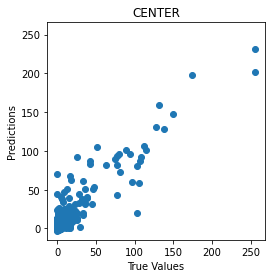

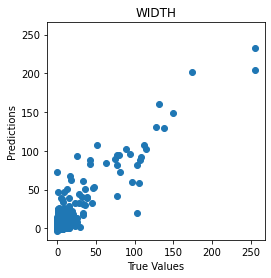

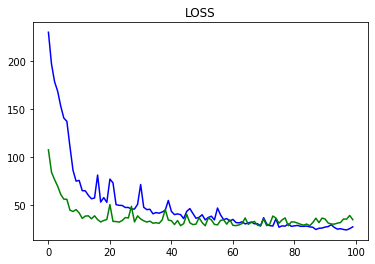

The accuracy of WindowCenter is 85.0%
The accuracy of WindowWidth is 74.0%
Mean absolute error of WindowCenter is 1.7699999809265137
Mean absolute error of WindowWidth is 2.8399999141693115
Mean squared error of WindowCenter is 16.950000762939453, RMSE: 4.119999885559082
Mean squared error of WindowWidth is 26.079999923706055, RMSE: 5.110000133514404


In [19]:
# make a prediction with the model
Y_pred = mo_model.predict(test_gen)
center_pred = Y_pred[0]
width_pred = Y_pred[1]

test_center = y_test[0]
test_width = y_test[1]

# difference between true and predicted values
plot_diff(test_center, center_pred, title='CENTER')
plot_diff(test_width, width_pred, title='WIDTH')

# plot loss
plot_metrics(mo_history, metric_name='loss', title='LOSS')

# calculate and print metrics
mo_score_center = r2_score(test_center, center_pred.reshape(-1))
print("The accuracy of WindowCenter is {}%".format(round(mo_score_center, 2) *100))
mo_score_width = r2_score(test_width, width_pred.reshape(-1))
print("The accuracy of WindowWidth is {}%".format(round(mo_score_width, 2) *100))

mo_mae_center =  mean_absolute_error(test_center, center_pred.reshape(-1))
print("Mean absolute error of WindowCenter is {}".format(round(mo_mae_center, 2)))
mo_mae_width =  mean_absolute_error(test_width, width_pred.reshape(-1))
print("Mean absolute error of WindowWidth is {}".format(round(mo_mae_width, 2)))

mo_mse_center = mean_squared_error(test_center, center_pred.reshape(-1))
print("Mean squared error of WindowCenter is {}, RMSE: {}".format(round(mo_mse_center, 2), round(np.sqrt(mo_mse_center), 2)))
mo_mse_width = mean_squared_error(test_width, width_pred.reshape(-1))
print("Mean squared error of WindowWidth is {}, RMSE: {}".format(round(mo_mse_width, 2), round(np.sqrt(mo_mse_width), 2)))